# Recalibration of SMP density coefficients
*Josh King, Environment and Climate Change Canada, 2020*

The matched snow pit and SMP measurements from Part 1 are used to recalibrate the bilinear regression model of [Proksch et al. (2015)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2014JF003266). We apply a K-Folds approach to minimize sampling bias while evaluating the OLS regression. 

In [114]:
# Import community packages
import string
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"

import matplotlib.cm as cm
import pickle

from scipy import stats
from statsmodels.formula.api import ols
from sklearn.model_selection import KFold, StratifiedShuffleSplit

# Seed to replicate the paper result exactly
RANDOM_SEED = 2019

# Load comparison result from Part 1
result = pd.read_pickle('./output/smp_pit_filtered.pkl')
result['force_log'] = np.log(result['force_median'])

## K-Folds OLS method

OLS regression with 10 folds to minimize sampling bias.
Model coefficients and skill are evaluated as the mean of all folds. 

In [115]:
k_fold = KFold(n_splits = 10, shuffle = True, random_state = RANDOM_SEED)
rmse = []; error = []; r = []; params = None

# Split the dataset into 10 roughly equal groups, 
# train on all but one test group
for train_idx, test_idx in k_fold.split(result):
    train = result.iloc[train_idx]
    test = result.iloc[test_idx]
    
    model_rho = ols("RHO ~ force_log + force_log * l", train).fit()
    predict_rho = model_rho.predict(exog=dict(force_log=test['force_log'], l=test['l']))
    rmse = np.append(rmse, np.sqrt(np.mean((predict_rho - test['RHO'])**2)))
    r = np.append(r,np.corrcoef(predict_rho, test['RHO'])[1][0])
    error = np.append(error, predict_rho - test['RHO'])
    
    if params is None:
        params = model_rho.params.values
    else:
        params =  np.vstack((params, model_rho.params.values))

In [116]:
# K20a evaluation stats (from k-folds method)
# Metrics presented as mean of all fold permutations

k20a_rmse = rmse.mean()
k20a_bias = error.mean()
k20a_r2 = r.mean()**2

print('K20a recalibration evaluation')
print('N: %i' % len(result))
print('RMSE: %0.1f' % k20a_rmse)
print('RMSE percent: %0.2f' % np.round(k20a_rmse/result.RHO.mean(),2))
print('bias: %0.1f' % k20a_bias)
print('r^2: %0.2f' % k20a_r2)

K20a recalibration evaluation
N: 784
RMSE: 65.4
RMSE percent: 0.22
bias: -0.0
r^2: 0.11


In [117]:
model_k20a_coeff = [np.round(params[:,0].mean(),2), np.round(params[:,1].mean(),2),
              np.round(params[:,3].mean(),2), np.round(params[:,2].mean(),2)]
var_coeffs = [np.round(params[:,0].std(),2), np.round(params[:,1].std(),2),
              np.round(params[:,3].std(),2), np.round(params[:,2].std(),2)]

# Unbiased coeffs
print(model_k20a_coeff)

# Save coeffs
filename = './output/density_k20a_coeffs.pkl'
pickle.dump(model_k20a_coeff, open(filename, 'wb'))

[285.47, 37.25, -32.26, -6.32]


In [118]:
# Apply the new coeffs to estimate density
k20a_rho = model_k20a_coeff[0]+(model_k20a_coeff[1]*result['force_log'])+ \
           (model_k20a_coeff[2]*result['force_log']*result['l'])+ \
           model_k20a_coeff[3]*result['l'] 

## K-folds OLS with outliers removed

Outliers were defined as SMP/Cutter comparisons where error > than the 95th quantile in the K20a recalibration.  
We justify this in the paper in the context of the matching procedure which cannot be assumed to be perfect.  
Note that this removes a small number of comparisons(n=10) which are not isolated to any one profile.

In [119]:
#Remove outliers
result_lim = result.copy()
result_lim['f_l'] = (result_lim['l'])*result_lim['force_log']
result_lim['abs_error'] = np.abs(k20a_rho - result_lim['RHO'])
q_95 = result_lim['abs_error'].quantile(0.95)
result_lim = result_lim[result_lim['abs_error'] < q_95]
n_removed  = len(result) - len(result_lim)

print('Error threshold: %i kg m^-3' % q_95)
print('Data points removed: %i' % n_removed)

Error threshold: 130 kg m^-3
Data points removed: 40


#### Figure 5 with caption
<img src="./output/figures/Fig05_RegressionTerms_lowres.png" alt="Figure 5" style="width: 800px;"/>

##### Comparison of the SMP regression parameters and corresponding snow density observations. Parameters include log-transformed median force (ln(F ̃)), microstructure length scale (L) and an interaction term (f ̃L). Relationships are separated by ice surface environment.'

In [120]:
print(list(result_lim))

['count_samp', 'mean_samp', 'median_samp', 'stdev_samp', 'index', 'Index', 'Bin', 'ScannerID', 'RHO', 'SSA', 'y', 'anisotropy', 'position in sample (mm)', 'position in snowpit(mm)', 'relative depth (%) ', 'BOTTOM', 'TOP', 'Height correction mm', 'ID', 'Location', 'Datetime', 'TYPE', 'relative_height', 'l', 'force_median', 'error', 'campaign', 'ice_type', 'lat', 'long', 'force_log', 'f_l', 'abs_error']


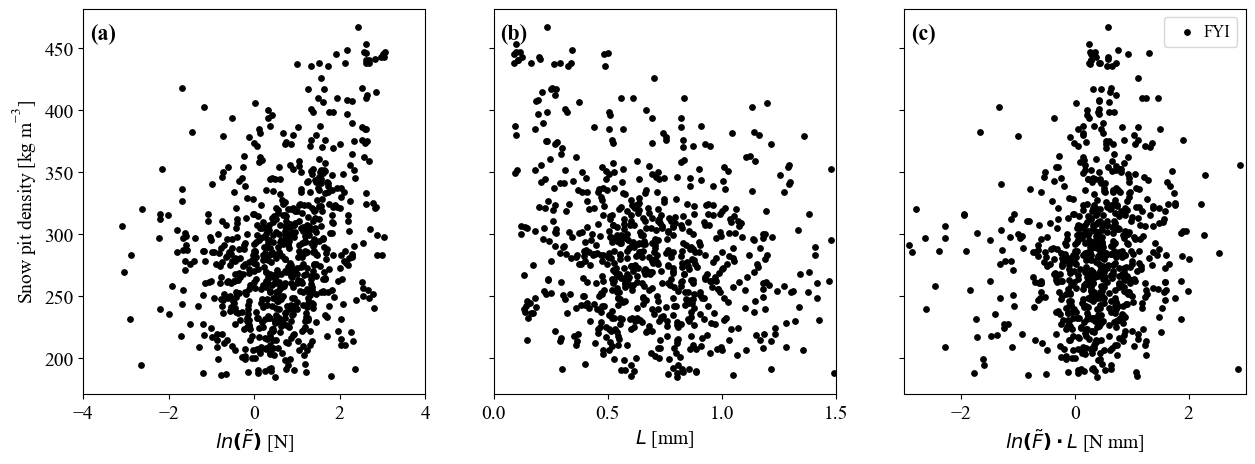

In [121]:
# Code to construct Figure 5
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,5))

axs = [ax1, ax2, ax3]
for n, ax in enumerate(axs):
    ax.text(0.02, 0.92, '('+string.ascii_lowercase[n]+')', transform=ax.transAxes, 
            size=16, weight='bold')

axis_value_size = 14
axis_label_szie = 14
point_size = 15

ax1.tick_params(axis='both', which='major', labelsize=axis_value_size)
ax2.tick_params(axis='both', which='major', labelsize=axis_value_size)
ax3.tick_params(axis='both', which='major', labelsize=axis_value_size)

kws_myi = dict(color = 'deepskyblue', s = point_size)
kws_fyi = dict(color = 'black', s = point_size)

ax1.scatter(result_lim['force_log'], #[result_lim['ice_type'] == 'f']
            result_lim['RHO'], #[result_lim['ice_type'] == 'f']
            label='FYI', **kws_fyi)
# ax1.scatter(result_lim[result_lim['ice_type'] == 'm']['force_log'], 
#             result_lim[result_lim['ice_type'] == 'm']['RHO'], 
#             label='MYI', **kws_myi)


ax2.scatter(result_lim['l'], #[result_lim['ice_type'] == 'f']
            result_lim['RHO'], #[result_lim['ice_type'] == 'f']
            label='FYI', **kws_fyi)
# ax2.scatter(result_lim[result_lim['ice_type'] == 'm']['l'], 
#             result_lim[result_lim['ice_type'] == 'm']['RHO'], 
#             label='MYI', **kws_myi)

ax3.scatter(result_lim['f_l'], #[result_lim['ice_type'] == 'f']
            result_lim['RHO'], #[result_lim['ice_type'] == 'f']
            label='FYI', **kws_fyi)
# ax3.scatter(result_lim[result_lim['ice_type'] == 'm']['f_l'], 
#             result_lim[result_lim['ice_type'] == 'm']['RHO'], 
#             label='MYI', **kws_myi)

ax1.set_ylabel('Snow pit density [kg m$\mathregular{^{-3}}$]', fontsize = axis_label_szie)
ax1.set_xlabel(r'$ln(\tilde{F})$ [N]', fontsize = axis_label_szie)
ax2.set_xlabel(r'$L$ [mm]', fontsize = axis_label_szie)
ax3.set_xlabel(r'$ln(\tilde{F}) \cdot L$ [N mm]', fontsize = axis_label_szie)

ax1.set_xlim(-4, 4)
ax2.set_xlim(0, 1.5)
ax3.set_xlim(-3, 3)

ax3.legend(fontsize = 12)
ax3.legend(handletextpad=0, fontsize=12)


f.savefig('./output/figures/Fig05_RegressionTerms_lowres.png', format='png')
f.savefig('./output/figures/Fig05_RegressionTerms_production.pdf', format='pdf', dpi = 300)

In [122]:
# Correlation between snow pit observed density and median force.L for all comparisons
print(np.round(np.corrcoef(result_lim.RHO, result_lim.force_log)[0][1],2))

0.32


In [123]:
# Correlation between snow pit observed density and median force, microstructural length scale and the interaction term
result_lim.groupby(['Location'])[['RHO','force_log','l','f_l']].corr()

RHO  force_log         l       f_l
Location                                                        
FR            RHO        1.000000  -0.247225  0.069878 -0.164771
              force_log -0.247225   1.000000 -0.388099  0.912225
              l          0.069878  -0.388099  1.000000 -0.642897
              f_l       -0.164771   0.912225 -0.642897  1.000000
RS3           RHO        1.000000   0.324362 -0.344677  0.097511
              force_log  0.324362   1.000000 -0.545909  0.894499
              l         -0.344677  -0.545909  1.000000 -0.212843
              f_l        0.097511   0.894499 -0.212843  1.000000
RS4           RHO        1.000000   0.296506 -0.137016  0.238512
              force_log  0.296506   1.000000 -0.153866  0.863658
              l         -0.137016  -0.153866  1.000000  0.100867
              f_l        0.238512   0.863658  0.100867  1.000000
Snow2-A2      RHO        1.000000   0.439478 -0.213275  0.382653
              force_log  0.439478   1.000000 -0.369607  0.921942
              l         -0.213275  -0.369607  1.000000 -0.222022
              f_l        0.382653   0.921942 -0.222022  1.000000
Snow2-A8      RHO        1.000000   0.096124 -0.228350 -0.072452
              force_log  0.096124   1.000000 -0.575821  0.895101
              l         -0.228350  -0.575821  1.000000 -0.593848
              f_l       -0.072452   0.895101 -0.593848  1.000000
ds-coring-SYI RHO        1.000000   0.417529  0.313181  0.393271
              force_log  0.417529   1.000000  0.007201  0.782434
              l          0.313181   0.007201  1.000000  0.580024
              f_l        0.393271   0.782434  0.580024  1.000000
radiation-stn RHO        1.000000   0.019424 -0.075534 -0.117641
              force_log  0.019424   1.000000 -0.538978  0.894038
              l         -0.075534  -0.538978  1.000000 -0.386103
              f_l       -0.117641   0.894038 -0.386103  1.000000
snow1-A3      RHO        1.000000   0.008087  0.397961  0.050001
              force_log  0.008087   1.000000 -0.560458  0.884210
              l          0.397961  -0.560458  1.000000 -0.208965
              f_l        0.050001   0.884210 -0.208965  1.000000
snow1-A5      RHO        1.000000   0.436207 -0.235950  0.322291
              force_log  0.436207   1.000000 -0.703861  0.912978
              l         -0.235950  -0.703861  1.000000 -0.511405
              f_l        0.322291   0.912978 -0.511405  1.000000
snow2-A2      RHO        1.000000   0.088263  0.179418  0.097030
              force_log  0.088263   1.000000 -0.461642  0.905156
              l          0.179418  -0.461642  1.000000 -0.336638
              f_l        0.097030   0.905156 -0.336638  1.000000
snow2-A8      RHO        1.000000   0.548045 -0.486424  0.135424
              force_log  0.548045   1.000000 -0.465968  0.747113
              l         -0.486424  -0.465968  1.000000 -0.034479
              f_l        0.135424   0.747113 -0.034479  1.000000
snow3-A6      RHO        1.000000   0.345230 -0.165941  0.098680
              force_log  0.345230   1.000000 -0.738436  0.825180
              l         -0.165941  -0.738436  1.000000 -0.675851
              f_l        0.098680   0.825180 -0.675851  1.000000

In [124]:
# Correlation between snow pit observed density and median force, microstructural length scale and the interaction term
result_lim.groupby(['campaign','Location'])[['RHO','force_log','l','f_l']].corr()

RHO  force_log         l       f_l
campaign Location                                                        
f1       FR            RHO        1.000000  -0.247225  0.069878 -0.164771
                       force_log -0.247225   1.000000 -0.388099  0.912225
                       l          0.069878  -0.388099  1.000000 -0.642897
                       f_l       -0.164771   0.912225 -0.642897  1.000000
         RS3           RHO        1.000000   0.324362 -0.344677  0.097511
                       force_log  0.324362   1.000000 -0.545909  0.894499
                       l         -0.344677  -0.545909  1.000000 -0.212843
                       f_l        0.097511   0.894499 -0.212843  1.000000
         RS4           RHO        1.000000   0.296506 -0.137016  0.238512
                       force_log  0.296506   1.000000 -0.153866  0.863658
                       l         -0.137016  -0.153866  1.000000  0.100867
                       f_l        0.238512   0.863658  0.100867  1.000000
         Snow2-A2      RHO        1.000000   0.439478 -0.213275  0.382653
                       force_log  0.439478   1.000000 -0.369607  0.921942
                       l         -0.213275  -0.369607  1.000000 -0.222022
                       f_l        0.382653   0.921942 -0.222022  1.000000
         Snow2-A8      RHO        1.000000   0.096124 -0.228350 -0.072452
                       force_log  0.096124   1.000000 -0.575821  0.895101
                       l         -0.228350  -0.575821  1.000000 -0.593848
                       f_l       -0.072452   0.895101 -0.593848  1.000000
         ds-coring-SYI RHO        1.000000   0.417529  0.313181  0.393271
                       force_log  0.417529   1.000000  0.007201  0.782434
                       l          0.313181   0.007201  1.000000  0.580024
                       f_l        0.393271   0.782434  0.580024  1.000000
         radiation-stn RHO        1.000000   0.019424 -0.075534 -0.117641
                       force_log  0.019424   1.000000 -0.538978  0.894038
                       l         -0.075534  -0.538978  1.000000 -0.386103
                       f_l       -0.117641   0.894038 -0.386103  1.000000
         snow1-A3      RHO        1.000000   0.008087  0.397961  0.050001
                       force_log  0.008087   1.000000 -0.560458  0.884210
                       l          0.397961  -0.560458  1.000000 -0.208965
                       f_l        0.050001   0.884210 -0.208965  1.000000
         snow1-A5      RHO        1.000000   0.436207 -0.235950  0.322291
                       force_log  0.436207   1.000000 -0.703861  0.912978
                       l         -0.235950  -0.703861  1.000000 -0.511405
                       f_l        0.322291   0.912978 -0.511405  1.000000
         snow2-A2      RHO        1.000000   0.088263  0.179418  0.097030
                       force_log  0.088263   1.000000 -0.461642  0.905156
                       l          0.179418  -0.461642  1.000000 -0.336638
                       f_l        0.097030   0.905156 -0.336638  1.000000
         snow2-A8      RHO        1.000000   0.548045 -0.486424  0.135424
                       force_log  0.548045   1.000000 -0.465968  0.747113
                       l         -0.486424  -0.465968  1.000000 -0.034479
                       f_l        0.135424   0.747113 -0.034479  1.000000
         snow3-A6      RHO        1.000000   0.345230 -0.165941  0.098680
                       force_log  0.345230   1.000000 -0.738436  0.825180
                       l         -0.165941  -0.738436  1.000000 -0.675851
                       f_l        0.098680   0.825180 -0.675851  1.000000

In [125]:
k_fold = KFold(n_splits = 10, shuffle = True, random_state = RANDOM_SEED)

rmse = []
error = []
r = []
params = None

for train_idx, test_idx in k_fold.split(result_lim):
    train = result_lim.iloc[train_idx]
    test = result_lim.iloc[test_idx]
    
    model_rho = ols("RHO ~ force_log + force_log * l + l", train).fit()
    predict_rho = model_rho.predict(exog=dict(force_log=test['force_log'], l=test['l']))
    rmse = np.append(rmse, np.sqrt(np.mean((predict_rho - test['RHO'])**2)))
    r = np.append(r,np.corrcoef(predict_rho, test['RHO'])[1][0])
    error = np.append(error, predict_rho - test['RHO'])
    
    if params is None:
        params = model_rho.params.values
    else:
        params =  np.vstack((params, model_rho.params.values))

In [126]:
# K20a evaluation stats (from kfolds method)
k20b_rmse = rmse.mean()
k20b_bias = error.mean()
k20b_r2 = r.mean()**2

print('K20b recalibration evaluation')
print('N: %i' % len(result_lim))
print('RMSE: %0.1f' % k20b_rmse)
print('RMSE percent: %0.2f' % np.round(k20b_rmse/result_lim.RHO.mean(),2))
print('bias: %0.1f' % k20b_bias)
print('r^2: %0.2f' % k20b_r2)

K20b recalibration evaluation
N: 744
RMSE: 51.5
RMSE percent: 0.18
bias: -0.2
r^2: 0.16


In [127]:
model_k20b_coeff = [np.round(params[:,0].mean(),2), np.round(params[:,1].mean(),2),
              np.round(params[:,3].mean(),2), np.round(params[:,2].mean(),2)]
var_coeffs = [np.round(params[:,0].std(),2), np.round(params[:,1].std(),2),
              np.round(params[:,3].std(),2), np.round(params[:,2].std(),2)]

# Unbiased coeffs
print(model_k20b_coeff)

# Save coeffs
filename = './output/density_k20b_coeffs.pkl'
pickle.dump(model_k20b_coeff, open(filename, 'wb'))

[277.68, 38.85, -36.08, -7.59]


In [128]:
k20b_rho = model_k20b_coeff[0]+(model_k20b_coeff[1]*result_lim['force_log'])+ \
           (model_k20b_coeff[2]*result_lim['force_log']*result_lim['l'])+ \
           model_k20b_coeff[3]*result_lim['l']

#### Figure 4 with caption
<img src="./output/figures/Fig04_ModelEval_lowres.png" alt="Figure 4" style="width: 600px;"/>

##### Evaluation of the SMP density model parametrization of Proksch et al. (2015) (P15; Top) and recalibrated coefficients for snow on sea ice (K19b; Bottom). In both cases the model is evaluated against manual density cutter measurements of snow density.

C:\Users\amyrm\AppData\Local\Temp\ipykernel_14512\3358453616.py:45: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax1.plot([line_start_a, line_end_a], [line_start_a, line_end_a],
C:\Users\amyrm\AppData\Local\Temp\ipykernel_14512\3358453616.py:62: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax3.plot([line_start_a, line_end_b], [line_start_a, line_end_b],


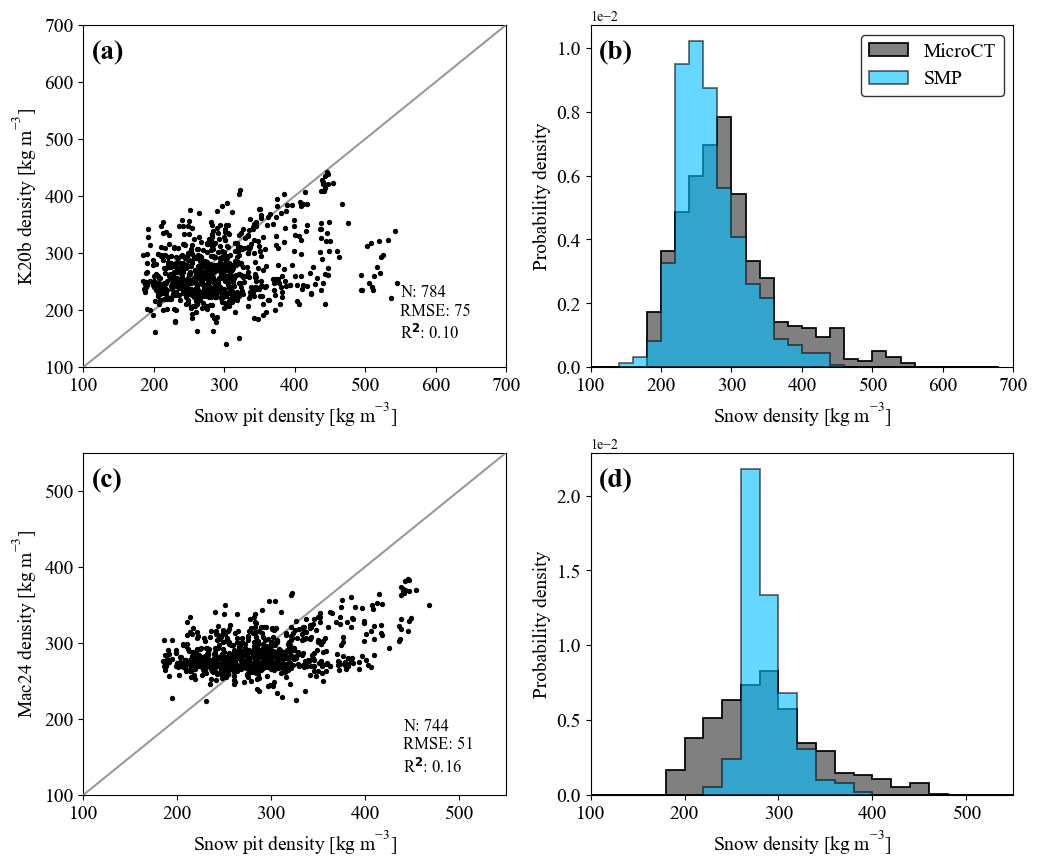

In [129]:
# Code to construct Figure 4
# P15 statistics
p2015_rmse = np.sqrt(np.mean((result['mean_samp']-result['RHO'])**2))
p2015_bias = (result['error']).mean()
p2015_r2 = np.ma.corrcoef(result['mean_samp'],result['RHO'])[0, 1]**2
p2015_n = len(result['mean_samp'])
p2015_p = stats.pearsonr(result['mean_samp'],result['RHO'])[1]


# Fig constants
axis_value_size = 14
axis_label_size = 14
rho_bin_size = 20 #in kg m-3
line_start_a = 100
line_end_a = 700
line_end_b = 550
point_size = 8
common_bin = np.arange(line_start_a,line_end_a, rho_bin_size)


f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,10))
f.subplots_adjust(hspace=.25)

axs = [ax1, ax2, ax3, ax4]
for n, ax in enumerate(axs):
    ax.text(0.02, 0.9, '('+string.ascii_lowercase[n]+')', transform=ax.transAxes, 
            size=20, weight='bold')

ax1.set_xlim(line_start_a,line_end_a)
ax1.set_ylim(line_start_a,line_end_a)
ax2.set_xlim(line_start_a,line_end_a)
ax3.set_xlim(line_start_a,line_end_b)
ax3.set_ylim(line_start_a,line_end_b)
ax4.set_xlim(line_start_a,line_end_b)

ax3.set_yticks(np.arange(line_start_a, line_end_b+1, 100.0))
ax1.tick_params(axis='both', which='major', labelsize=axis_value_size)
ax2.tick_params(axis='both', which='major', labelsize=axis_value_size)
ax3.tick_params(axis='both', which='major', labelsize=axis_value_size)
ax4.tick_params(axis='both', which='major', labelsize=axis_value_size)


ax1.scatter(result['RHO'], result['mean_samp'], 
            s = point_size, color ='black', zorder = 1000)
ax1.plot([line_start_a, line_end_a], [line_start_a, line_end_a], 
         'k-', color = 'gray' ,alpha= 0.8, zorder = 500)

hist_kws = dict(density=True, bins=common_bin, histtype="stepfilled", linewidth=1.25)
ax2.ticklabel_format(axis='y',style='sci', scilimits=(1,5), useMathText=False)
ax2.hist(result['RHO'], alpha = 1, edgecolor="black", 
         color = 'grey', label = 'MicroCT', **hist_kws)
ax2.hist(result['mean_samp'], alpha = 0.6, edgecolor="black", 
         color = 'deepskyblue', label = 'SMP', **hist_kws)

ax1.set_ylabel('K20b density [kg m$\mathregular{^{-3}}$]', fontsize=axis_label_size)
ax1.set_xlabel('Snow pit density [kg m$\mathregular{^{-3}}$]', fontsize=axis_label_size)
ax2.set_ylabel('Probability density', fontsize=axis_label_size)
ax2.set_xlabel('Snow density [kg m$\mathregular{^{-3}}$]', fontsize=axis_label_size)
ax2.legend(edgecolor = 'black',  fontsize=axis_value_size)

ax3.scatter(result_lim['RHO'], k20b_rho, s = point_size, color ='black',  zorder = 1000)
ax3.plot([line_start_a, line_end_b], [line_start_a, line_end_b], 
         'k-', color = 'grey' ,alpha= 0.8,  zorder = 500)

hist_kws = dict(density=True, bins = common_bin, histtype= "stepfilled", linewidth = 1.25)
ax4.ticklabel_format(axis='y',style='sci', scilimits=(1,5), useMathText=False)

ax4.hist(result_lim['RHO'], alpha = 1, edgecolor="black", color = 'grey', label = 'MicroCT', **hist_kws)
ax4.hist(k20b_rho, alpha = 0.6, edgecolor="black", color = 'deepskyblue', label = 'SMP', **hist_kws)

ax3.set_ylabel('Mac24 density [kg m$\mathregular{^{-3}}$]',fontsize=axis_label_size)
ax3.set_xlabel('Snow pit density [kg m$\mathregular{^{-3}}$]',fontsize=axis_label_size)
ax4.set_ylabel('Probability density',fontsize=axis_label_size)
ax4.set_xlabel('Snow density [kg m$\mathregular{^{-3}}$]',fontsize=axis_label_size)

# Display stats
ax1.text(550, 150,'N: %i \nRMSE: %i \nR$^2$: %0.2f'%(p2015_n, p2015_rmse, p2015_r2), fontsize=12)
ax3.text(440, 130,'N: %i \nRMSE: %i \nR$^2$: %0.2f'%(len(result_lim), k20b_rmse, k20b_r2),  fontsize=12)

f.savefig('./output/figures/Fig04_ModelEval_lowres.png', format='png')
f.savefig('./output/figures/Fig04_ModelEval_production.pdf', format='pdf', dpi = 300)

In [130]:
# Error metrics
def rmse(data):
    return np.sqrt(np.mean(data**2))

result_lim['model_rho'] = k20b_rho
result_lim['abs_error'] = np.abs(k20b_rho-result_lim['RHO']).values
result_lim['error'] = (k20b_rho-result_lim['RHO']).values

# Error by layer type
np.round(result_lim.groupby('TYPE')['error'].apply(rmse)/result_lim.groupby('TYPE')['model_rho'].mean(),3)

TYPE
N    0.179
dtype: float64

In [131]:
np.round(result_lim.groupby('campaign')['error'].apply(rmse)/result_lim.groupby('campaign')['model_rho'].mean(),3)

campaign
f1    0.179
dtype: float64

In [132]:
# Overall error in %
np.round((rmse(result_lim['error'])/result_lim['model_rho'].mean()),3)

0.179